# Знакомство с датасетом и baseline

## План работы

(I) Знакомство с датасетом и baseline

1. Познакомиться с датасетом - найти фишки, уникальность в данных и интересные закономерности

2. Формализовать концепт для решения задачи - любой подходящий вариант

3. Подготовить набор функций для моделирования

4. Реализовать baseline c минимальной подготовкой данных

5. На основе выводов сгенерировать идеи для возможных подходов к задаче.

6. Сформировать план дальнейшей работы и тестирования


(II) Поиск решения для задачи:

1. Предобработка датасета и реализация нескольких подходов

2. Исследовательский анализ данных и оценка узких мест

3. Оценка возможностей подходов (baseline) - успех нашего проекта)

3. Идеи для артефактов


(III) Моделирование:

1. Подбор алгоритмов и библиотек для реализации

2. Подготовка готовых модулей и классов

3. Feature Engineering и достижение качества



(IV) Подготовка артефактов!


## Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set()
sns.set_style('whitegrid') 

## Знакомство с данными

### Вводные

Создадим свою историю для каждого читателя библиотеки! Найдем 20 лучших рекомендаций для новых книг:)

Всего у нас 3 датасета:

- читатели
- книги
- "транзакции" - история работы с библиотекой

Исследование начнем с самого интересного и узнаем:

- как `активно читают` наши **пользователи**, и есть ли у них что-то `общее`


- за какой период у нас есть данные и какой **объем книг в ТОПе** у читаталей


- есть ли какие-то интересные поля, которые мы могли бы использовать для `персональных рекомендаций`


Самое главное - выяснить, в чем особенность и изюминка именно нашей библиотеки, и найти идеи для уникального алгоритма рекомендаций:)


### Загрузка данных

У нас в руках по-настоящему большая и интересная библиотека, ~ 350 000 позиций.

Разобьем датасет с книгами на 5 частей, так мы сэкономим ресурсы и сможем быстрее провести анализ данных (воспользуемся бесплатным ресурсом https://extendsclass.com/csv-splitter.html).

In [12]:
# Загрузка данных
df_users = pd.read_csv('users.csv', sep=';', index_col=None, dtype={'age': str, 'chb': str, 'chit_type': str, 'gender': str})
df_books_1 = pd.read_csv('books1.csv', sep=';', index_col=None, dtype={'author': str, 'bbk': str, 'izd': str, 'sys_numb': str, 'title': str, 'year_izd': str})
df_actions = pd.read_csv('train_transactions_extended.csv', sep=';', index_col=None, dtype={'chb': str, 'date_1': str, 'is_printed': str, 'is_real': str, 'source': str, 'sys_numb': str, 'type': str})

### Кто посещает библиотеку?

In [13]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16753 entries, 0 to 16752
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   chb        16753 non-null  object
 1   age        16753 non-null  object
 2   gender     16753 non-null  object
 3   chit_type  16753 non-null  object
dtypes: object(4)
memory usage: 523.7+ KB


In [14]:
df_users.gender.value_counts()

female         10407
male            6332
не указан         13
отсутствует        1
Name: gender, dtype: int64

In [15]:
df_users.chit_type.value_counts()

нет данных     13098
echb            2183
normal          1471
отсутствует        1
Name: chit_type, dtype: int64

**Вывод 1**

- Среди читателей почти в `2 раза меньше мужчин`, интересно, какая статистика по всей стране)


- Поле `chit_type` нам не будет полезным, т.к. остутствует у большинства пользователей

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


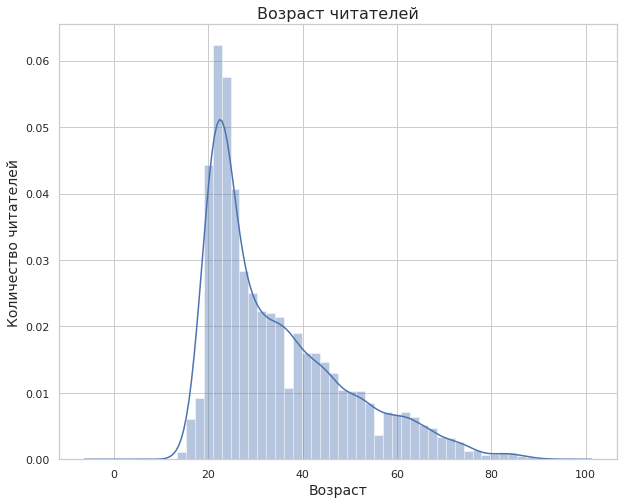

In [16]:
plt.figure(figsize=(10, 8))
sns.distplot(df_users.age.replace('отсутствует'));
plt.title(label="Возраст читателей", size=16)
plt.xlabel("Возраст", fontsize=14)
plt.ylabel("Количество читателей", fontsize=14)
plt.show();

In [17]:
df_users.age.describe()

count     16753
unique       81
top          22
freq       1118
Name: age, dtype: object

In [18]:
df_users.age.sort_values()

8978               0
2435              14
15644             14
15272             14
1129              14
            ...     
14275             90
55                90
14182             91
14003             95
9681     отсутствует
Name: age, Length: 16753, dtype: object

**Вывод 2**


- Средний возраст читателей `22 года` - но это необязательно самые **активные** читатели)


- Видно, что выделяются **возрастные группы**  - можем попробовать использовать в предсказаниях (вместе с полем `gender`)

Первый раз библиотеку посещают ребята в 14 лет. Есть и долгожители! Самому закаленному 95 лет))

### Книги, которые читают

`Общие интересы` читателей - книги, которые они читают)

- Посмотрим, есть ли в библиотеке **книги**, о которых уже могут рассказать `разные пользователи`? 


- Если да, то мы сможем их использовать для поиска **похожих читателей**:)

In [ ]:
books_popularity = (df_actions.groupby('sys_numb')
                    .chb.count().rename('users_count')
                    .to_frame())

In [ ]:
df_actions[df_actions.chb.isin(df_users.chb)].groupby('sys_numb').chb.count().describe()

- 90% книг прочитали всего один раз!  

- Если обучить нашу рекомендательную систему, то она поможет `поделиться книгами` с другими пользователями))

Остались `10% самых важных книг`, по ним мы могли бы **объединить** наших читателей по интересам

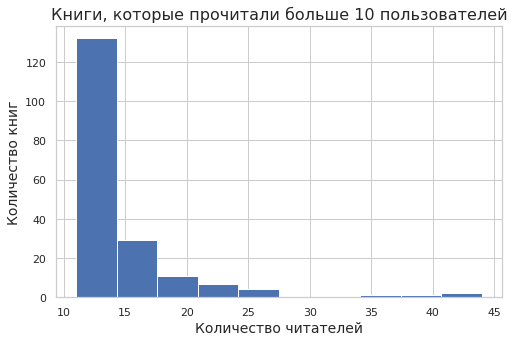

In [21]:
books_popularity[books_popularity > 10].hist(figsize=(8, 5));
plt.title(label="Книги, которые прочитали больше 10 пользователей", size=16)
plt.xlabel("Количество читателей", fontsize=14)
plt.ylabel("Количество книг", fontsize=14)
plt.show()

**Вывод**

- Можно попробовать разделить книги по `трем кластерам` в зависимости от **популярности**


- Для `16 000 пользователей` есть всего **200 книг**, чтобы объединить их вместе. Для ML обучения это даже хорошо, будет меньше признаков;)


Есть несколько **уникальных** - больше 35 читателей! Очень интересно, что это за книги?

In [22]:
df_books_1[df_books_1.sys_numb.isin(books_popularity.query('users_count > 35').index)]

,sys_numb,title,author,izd,year_izd,bbk
90,RSL07000449201,отсутствует,отсутствует,отсутствует,отсутствует,отсутствует
635,RSL01006724299,"Коллекционеры России, XVII - начало XX вв. : э...","Полунина, Надежда Михайловна",РИПОЛ классик,2005,Щ101.3(2)д.я22\nЧ778.3(2)-8я22
4004,RSL01004357029,"Переписка В. А. Жуковского и А. П. Елагиной, 1...",none,Знак,2009,"Ш5(2=Р)51-4Жуковский В.А.13,0"


Нам повезло! Топовые книжки попали в первую часть датасета)


Переписка Жуковского..очень неожиданно, но вот погуглила и не смогла оторваться - как можно было писать такие письма. 
После окончания проекта пойду во все тяжкие и прочту хотя бы часть этого произведения)

In [ ]:
df_actions.plot(kind='scatter', x= 'chb', y = 'sys_numb')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='chb', ylabel='sys_numb'>

#### Любимые жанры

К сожалению, в нашем датасете `нет информации` о жанрах.

- для предсказаний и рекомендаций это очень **важный признак**

- можно попробовать его "распарсить" из кода `bbk`!

In [ ]:
df_books_1.bbk

Много пустых полей - `отсутствует` и `none`

In [ ]:
print("Количество книг с bbk:")
(df_books_1[
    (df_books_1.bbk != 'отсутствует') 
    & (df_books_1.bbk != 'none')]
).shape[0]

In [ ]:
print("Есть ли bbk у книги, которые уже выдавались в библиотеке:")
df_books_1[df_books_1.sys_numb.isin(df_actions.sys_numb)]

**Вывод**

1. Для жанров мы можем `распарсить` поле bkk

    - Будет много книг "без жанра", но кто не пробует, тот не пьет шампанского)


2. Также отметим, что есть **книги-шпионов** - их читают, но в БД вся информация отсутствует 

    - Учтем в предобработке данных для обучения

#### Популярные авторы

Мы еще не проводили предобработку текста в датасете. Посмотрим, насколько хорошо ведется БД.

In [ ]:
(df_books_1[
    df_books_1.sys_numb.isin(df_actions.sys_numb)]
).groupby('author').sys_numb.count().sort_values().tail(100)

**Вывод**

Даже без дополнительной **обработки текста** мы сможем сгруппировать книги по авторам


- У нас `~100 популярных авторов`


- Похоже, "серьезная" литература пользуется наибольшим спросом среди читателей

### Активность пользователей

#### Датасет с транзакциями

История библиотеки у нас в `файле с транзакциями` - здесь хранятся самые важные данные о **выдаче книг**.

In [ ]:
df_actions.head(7)

Пара `chb`(читатель) - `sys_numb`(книга) - ключ ко всем вопросам) 

В ящике пандоры у нас всего 5 дополнительных полей:

- `is_real`- была ли выдана книга
- `date_1` - скачана онлайн или читатель пришел в библиотеку
- `source` - откуда была взята книга
- `is_printed` - распечатавали ли книги

К ним мы вернемся чуть позже, а пока сфокусируемся на **активности** читателей. 

#### Количество книг в руках читателей

Посмотрим, какой `объем книг` в среднем прочитывают пользователи нашей библиотеки.

In [ ]:
df_actions.groupby('chb').sys_numb.count().sort_values(ascending=False)

- `6000 книг!` вот это рекордсмен)) Или ошибка, или действительно есть такие книгоманы:)


- Может быть, он просто регулярно брал книги в библиотеке?))

Проверим!

In [ ]:
print("Уникальный пользователь, который взял 6000 книг")
df_users[df_users.chb == "200000872413"]

- Даже если читать с 10 лет, то в среднем это `150 книг в год` или  12 в месяц))

- Еще одна версия - много внуков) каждому по паре тройке книг:)

In [ ]:
plt.figure(figsize=(8, 5))
(df_actions
 .groupby('chb').filter(lambda x : x['chb'].count() < 50)
 .groupby('chb').chb.count().hist())
plt.title(label="Пользователи, которые прочитали < 50 книг", size=16)
plt.xlabel("Количество книг", fontsize=14)
plt.ylabel("Количество читателей", fontsize=14)
plt.show();

In [ ]:
df_actions.groupby('chb').sys_numb.count().describe()

In [ ]:
df_actions.groupby('chb').sys_numb.count().quantile(0.99)

**Вывод**

- `75% читателей1 имеет в арсенале не больше **14 книг**, и `только 1%` - больше **100 книг**


- Для рекомендательных систем обычно отбираются пользователи с количеством книг > 100 :) Уже уникальный случай)


- У нас очень сильно `разношерстная аудитория` по объему чтения (3000 книг и 5 книг)


Такие показатели зависят не только от **активности** читателей и их **возраста**, но также могут выделять `новых пользователей` библиотеки.

Напрашивается подход с СЕГМЕНТАЦИЕЙ! Посмотрим, какие еще признаки сможем найти для пользователей.

#### Как часто читатели берут книги?

Для начала оценим `временной период`, за который у нас есть данные (заодно проверим их актуальность и новизну).

Первым шагом отформатируем столбец с датами.

In [ ]:
df_actions.date_1

In [ ]:
# Смотрим, какой тип данных у дат
df_actions.dtypes

In [ ]:
# Форматируем дату
df_actions['date_1'] = pd.to_datetime(df_actions['date_1'])

# Проверяем тип данных
df_actions.dtypes

In [ ]:
# Индексируем датасет по дате и делаем сортировку
df_actions = (df_actions
                .set_index('date_1')
                .sort_index()
             )

In [ ]:
# Отобразим на графике активность библиотеки по  месяцам
plt.figure(figsize=(10,6))
(df_actions
     .resample('1M')
     .chb.count()
     .plot(grid=True, style='o-'))     

plt.title('Количество ежемесячно выдаваемых книг в библиотеке', fontsize=14)
plt.show()

**Вывод**

1. У нас совсем свежие данные - за `два последних года`! Этим и объясняется небольшое количество книг у большинства пользователей)
    - Видно, что летом активность спала - все уехали в отпуска и на каникулы (вместе со школьным списком литературы)
    - Интересно, а как же тогда удалось набрать 6000 позиций?
    
    
2. Для такой системы еще рано делать **рекомендации** на основе `предсказаний` - лучше предлагать читателям разные книги:

    - ТОП-20 самых популярных

    - "Похожие пользователи также читают..."

    - "Читателям данной книги также были интересны..."

И набирать обратную связь с рейтингом:)

#### Самые активные пользователи

Вернемся к нашему рекордсмену с 6000 книгами и снова построим график выдачи книг по месяцам.

- либо это какая-то организация, для которой одно лицо получает все книги

- либо массовое скачивание в интернете))

In [ ]:
# Отобразим на графике активность библиотеки по  месяцам
plt.figure(figsize=(10,6))
(df_actions
     .query('chb == "200000872413"')
     .resample('1M')
     .chb.count()
     .plot(grid=True, style='o-'))     

plt.title('Статистика пользователя с 6000 книгами за 2 года', fontsize=14)
plt.xlabel("Месяц", fontsize=14)
plt.ylabel("Количество выданных книг", fontsize=14)
plt.show();
plt.show()

- 1000 книг за 1 месяц, хмм.. посмотрим еще других рекордсменов

In [ ]:
print("Читатели, взявшие самое большое количество книг:")
(df_actions.groupby('chb')
 .sys_numb.count()
 .sort_values(ascending=False)
 .head(10))

- Мы могли бы считвть двух верхних пользователей (`> 3000 книг`)  какой-то **ошибкой**


- Есть много тех, кто получил `~1000 книг`. Попробуем проверить наши гипотезы выше.

In [ ]:
plt.figure(figsize=(10,6))
(df_actions
     .query('chb == "300001058749"')
     .resample('1M')
     .chb.count()
     .plot(grid=True, style='o-'))     

plt.title('Статистика пользователя с 1600 книгами за 2 года', fontsize=14)
plt.xlabel("Месяц", fontsize=14)
plt.ylabel("Количество выданных книг", fontsize=14)
plt.show();

- Скачивал ли он книги **через интернет**?


- Возможно, есть **дубликаты** книг - для нескольких людей?

In [ ]:
df_actions.query('chb == "300001058749"')

- Ага, все электронные. А если проверим других топовых читателей?

In [ ]:
print("Типы выданных книг `is_printed` для ТОП-10 читателей (> 1000 книг):")

df_actions[
    df_actions.chb.isin(
        (df_actions.groupby('chb')
         .sys_numb.count()
         .sort_values(ascending=False)
         .head(10).index)
    )].is_printed.value_counts()

**Вывод 1**

- Возможно, `is_printed` - это все-таки относится к онлайн-сервисам


- Книговыдача -  как свяана с не может быть is_printed?


- Проверим статистику по книгам, выданным именно на руки! None

### Привычки читателей

Как и планировали, посмотрим, какие у нас еще есть "следы" в поведении читателей - 

In [ ]:
sns.countplot(data=df_actions, x='is_real')
plt.show() 

Поле `is_real`, скорее всего, нам не пригодится:
 - в 99% случаев книги были переданы в надежные руки читателя:)     

In [ ]:
sns.countplot(data=df_actions, x='type')
plt.show() 

In [ ]:
sns.countplot(data=df_actions, x='source')
plt.show() 

У нас целых **4 источника** для просмотра книг `source`:

- 3 онлайн-платформы 

- `None` - если читатель нашел книгу на полках в библиотеке?

График источников практически **совпадает** с типом выдачи `type` (по количеству транзакций):

- dlib -> скачивание

- None -> None

- 2D -> Книговыдача

- Удаленный просмоторщик -> Книговыдача

2-й сайт(`None`) самый популярный. Возможно, это все-таки информационная система в самой библиотеке?

In [ ]:
sns.countplot(data=df_actions, x='is_printed')
plt.show()  

**Половина** прочитанных книг `is_printed` - печатные документы, половина - электронные.

- Здорово, это хороший показатель для современной библиотеки)


Теперь все карты сложились: 

- **"бумажных" книг** ровно 140000 - столько же было выдано 2-м источником(`None`)


- получается, это книги взятые в самой библиотеке (и зарегистрированные во внутренней ИС)

**Вывод**

Возможно, часть пользователей предпочитает держать `книги в руках`, а у других есть **любимые сайты**. 

- Будет здорово, если это поможет еще лучше **сегментировать** наших читателей


- Можно создать несколько подобных `признаков` и протестировать в системе рекомендаций!

## Общий вывод и вопросы

Можно объединить книги и пользователей в кластеры, посмотреть, что найдет алгоритм)

- возраст, пол 

- количество прочитанных книг

- количество книг прочитанных за период (месяц)

- 200 книг (тех самых)

- предпочтения по книгам (сайты, бумажные версии)

- любимые авторы  

Книги:

- авторы

- жанры

- год издания

- количество читателей (книги)

Жанры можно попробовать найти по bbk.


Можно взять только 100000 книг, которые уже прочитали

====

2. Для такой системы еще рано делать **рекомендации** на основе `предсказаний` - лучше предлагать читателям разные книги:

    - ТОП-20 самых популярных

    - "Похожие пользователи также читают..."

    - "Читателям данной книги также были интересны..."

## Тестирование платформы

## Первая идея для реализации

### Концепт

Информация в transaction только о прочитанных (целевых) книгах - не сможем использовать для предсказаний,
но можем использовать для отсева аутлайеров

Каждый пользователь мало читает - сделать фокус на общей группе книг:

- Найти кластеры и для них сделать рекомендации
- Посчитать вероятность для целевых книг - сможем ли предсказать? Какие факторы влияют?
- Можно ли рандомно разделить по пользователям, чтобы попасть в hitrate



### Формализация задачи

Так как у нас **нет рейтинга** пользователей, то цель предсказаний - найти наиболее `релевантные` книги для каждого читателя.

- Релевантные/ не релевантные - `бинарная` классификация


- Наиболее подходящие книги - нам важны **вероятности**

Целевой признак - понравится ли новая книжка читателю (если да, то он обязательно `возьмет` ее с книжной полки или скачает)

### Метрики для оценки качества

**TOP-20** рекомендаций

1. Какой процент книжек мы отловили? Наш hit rate:)

`Recall` - количество релевантных рекомендаций / количество взятых книг 

0.8 => модель может отловить все 80% интересных книжек

====================================================================================

2. Сколько книг нужно будет посоветовать, чтобы попасть в яблочко и угадать ту самую?

`Precision` - количество релевантных рекомендаций / общее количество рекомендаций

0.2 => модель выдает много нерелевантных рекомендаций, только 20% полезны пользователям

**Вывод**

1. Делаем гипотезу, что модель оценивает попадние в яблочко для ГРУППЫ пользователей (если рандомно смешаем рекомендации - качество останется тем же).

- Для precision@k такое решение должно быть нерелевантным

- Можно использовать алгоритм KNN и найти наиболее близкие книги! К нашим 100 000

2. Вопросы:

- Какое количество читаталей в тестовой выборке?

- Какое количество книг на каждого читателя?

- Как делится train и test (попадают ли книги не из transaction)?